In [2]:
import locale
from os import chdir, path

import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from adjustText import adjust_text
from sklearn.metrics import r2_score

from custom.plots import aggiorna_ascissa
from custom.watermarks import add_watermark

In [3]:
paesi_abitanti_eu = {"Austria": 8.917, "Belgium": 11.56, "Bulgaria": 6.927,
                     "Cyprus": 1.207, "Croatia": 4.047, "Denmark": 5.831,
                     "Estonia": 1.331, "Finland": 5.531, "France": 67.39,
                     "Germany": 83.24, "Greece": 10.27, "Ireland": 4.995,
                     "Italy": 59.55, "Latvia": 1.902, "Lithuania": 2.795,
                     "Luxembourg": 0.632275, "Malta": 0.525285, "Netherlands": 17.44,
                     "Poland": 37.95, "Portugal": 10.31, "Czechia": 10.7,
                     "Romania": 19.29, "Slovakia": 5.549, "Slovenia": 2.1,
                     "Spain": 47.35, "Sweden": 10.35, "Hungary": 9.75}

paesi_eu_ita = ["Austria", "Belgio", "Bulgaria", "Cipro", "Croazia", "Danimarca",
                "Estonia", "Finlandia", "Francia", "Germania", "Grecia", "Irlanda",
                "Italia", "Lettonia", "Lituania", "Lussemburgo", "Malta", "Olanda",
                "Polonia", "Portogallo", "Repubblica Ceca", "Romania", "Slovacchia",
                "Slovenia", "Spagna", "Svezia", "Ungheria"]


# Importa dati vaccini e dati epidemiologici
def import_vaccines_data():
    """ Recupera dati sui vaccini da Our World in Data"""

    url = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv"  
    df_vacc = pd.read_csv(url)
    df_vacc = df_vacc.fillna(method="ffill")
    return df_vacc


def get_vaccine_data(country, df_vacc):
    """ Recupera dati vaccini per paese """

    df_vacc_country = df_vacc[df_vacc["location"] == country].iloc[2:, :]

    date = pd.to_datetime(df_vacc_country["date"])
    vacc1 = np.array(df_vacc_country["people_vaccinated_per_hundred"])
    vacc2 = np.array(df_vacc_country["people_fully_vaccinated_per_hundred"])

    df_vacc_new = pd.DataFrame(np.transpose([vacc1, vacc2]))
    df_vacc_new.index = date
    df_vacc_new.columns = ["% vaccinated with 1 dose", "% fully vaccinated"]

    return df_vacc_new


def import_epidem_data():
    """ Recupera dati epidemiologici dal JHU CSSE
        (Johns Hopkins Unversity)"""

    base = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"  # noqa: E501
    file_confirmed = base + "time_series_covid19_confirmed_global.csv"
    file_deaths = base + "time_series_covid19_deaths_global.csv"
    file_recovered = base + "time_series_covid19_recovered_global.csv"
    return pd.read_csv(file_confirmed), pd.read_csv(file_deaths), pd.read_csv(file_recovered)


def get_epidemic_data(country, df_confirmed, df_deaths, df_recovered):
    """ Recupera dati epidemiologia per paese """
    ydata_cases = (df_confirmed[df_confirmed["Country/Region"] == country].iloc[:, 4:]).sum()
    ydata_deaths = (df_deaths[df_deaths["Country/Region"] == country].iloc[:, 4:]).sum()
    ydata_rec = (df_recovered[df_recovered["Country/Region"] == country].iloc[:, 4:]).sum()
    ydata_inf = ydata_cases-ydata_deaths-ydata_rec
    daily_cases = ydata_cases.diff().rolling(window=7).mean()
    daily_deaths = ydata_deaths.diff().rolling(window=7).mean()
    df_epidemic = pd.DataFrame(np.transpose([ydata_cases,
                                             ydata_inf,
                                             ydata_deaths,
                                             ydata_rec,
                                             daily_cases,
                                             daily_deaths]))
    df_epidemic.index = pd.to_datetime(df_confirmed.columns[4:])
    df_epidemic.columns = ["Total cases",
                           "Active infected",
                           "Total deaths",
                           "Total recovered",
                           "Daily cases (avg 7 days)",
                           "Daily deaths (avg 7 days)"]
    return df_epidemic


def get_vaccine_data_last(country, time_window=30, t0=-1, fully=True, last_day=False):
    """ Recupera dati sulla frazione di vaccinati
        medi negli ultimi 30 giorni """

    df_vacc_country = df_vacc[df_vacc["location"] == country].iloc[2:, :]
    vacc_fully = np.array(df_vacc_country["people_fully_vaccinated_per_hundred"
                                          if fully else
                                          "people_vaccinated_per_hundred"])
    vacc_ultimi_Ngiorni = np.mean(vacc_fully[t0-(time_window+1):t0
                                             if last_day
                                             else -1])
    return vacc_ultimi_Ngiorni


def get_deaths(country, time_window=30, t0=-1):
    """ Recupera decessi per la finestra temporale selezionata """
    decessi = np.array(df_deaths[df_deaths["Country/Region"] == country].iloc[:, 4:].sum())
    decessi_ultimi_Ngiorni = decessi[t0] - decessi[t0-time_window]
    return decessi_ultimi_Ngiorni

def get_cases(country, time_window=30, t0=-1):
    """ Recupera decessi per la finestra temporale selezionata """
    casi = np.array(df_confirmed[df_confirmed["Country/Region"] == country].iloc[:, 4:].sum())
    casi_ultimi_Ngiorni = casi[t0] - casi[t0-time_window]
    return casi_ultimi_Ngiorni


def compute_vaccini_decessi_eu(tw, fully=True, last_day=False):
    """ calcola vaccini e decessi nei 27 Paesi europei """

    dec_res_2021 = []
    vacc_res_2021 = []
    t0 = -1
    for p, abitanti in paesi_abitanti_eu.items():
        vacc_res_2021.append(get_vaccine_data_last(p,
                                                   time_window=tw,
                                                   fully=fully,
                                                   last_day=last_day))
        dec_res_2021.append(get_deaths(p, time_window=tw, t0=t0)/abitanti)
    dec_res_2021 = np.array(dec_res_2021)
    return vacc_res_2021, dec_res_2021


def compute_vaccini_casi_eu(tw, fully=True, last_day=False):
    """ calcola vaccini e decessi nei 27 Paesi europei """

    casi_res_2021 = []
    vacc_res_2021 = []
    t0 = -1
    for p, abitanti in paesi_abitanti_eu.items():
        vacc_res_2021.append(get_vaccine_data_last(p,
                                                   time_window=tw,
                                                   fully=fully,
                                                   last_day=last_day))
        casi_res_2021.append(get_cases(p, time_window=tw, t0=t0)/(abitanti*10))
    casi_res_2021 = np.array(casi_res_2021)
    return vacc_res_2021, casi_res_2021


def linear_model(x, coeff_fit):
    y = coeff_fit[1] + coeff_fit[0]*x
    return y


def linear_fit(vacc_res_2021, dec_res_2021):
    """ fit lineare """

    coeff_fit = np.polyfit(vacc_res_2021, dec_res_2021, 1)
    x_grid = np.arange(0, 100, 1)
    y_grid = [linear_model(v, coeff_fit) for v in x_grid]

    # calcola R2 score
    y_pred = [linear_model(v, coeff_fit) for v in vacc_res_2021]
    y_test = dec_res_2021

    score = round(r2_score(y_test, y_pred), 2)
    print('R2 score è pari a', score)

    return x_grid, y_grid, score


def corr_window(tw):
    """ Recupera dati decessi e vaccini per la finestra
        temporale e i paesi selezionati """

    dec_res = []
    vacc_res = []
    for p, abitanti in paesi_abitanti_eu.items():
        vacc_res.append(get_vaccine_data_last(p, fully=True, last_day=True))
        dec_res.append(get_deaths(p, time_window=tw)/abitanti)
    corr_tw = np.corrcoef(vacc_res, dec_res)[0, 1]
    return corr_tw


def compute_max_correlation():
    """ calcola la finestra temporale in cui si ottiene
        la massima correlazione """

    tw_grid = np.arange(7, 300, 5)
    corr_grid = [corr_window(tw) for tw in tw_grid]
    ideal_window = tw_grid[np.argmin(corr_grid)]
    return ideal_window


def map_vaccinated(f_vacc):
    if f_vacc >=20 and f_vacc < 40:
        return "20%-40%"
    elif f_vacc >=40 and f_vacc < 60:
        return "40%-60%"
    elif f_vacc >=60 and f_vacc < 80:
        return "60%-80%"
    elif f_vacc >=80 and f_vacc <= 100:
        return "80%-100%"


def group_vaccinated(vacc_res_2021, dec_res_2021):
    df_res = pd.DataFrame(vacc_res_2021, columns=["vaccinati"])
    df_res["deceduti"] = dec_res_2021
    df_res["vacc_mapped"] = df_res["vaccinati"].apply(map_vaccinated)
    df_grouped = df_res.groupby("vacc_mapped").mean()["deceduti"]
    return df_grouped

def plot_correlazione_vaccini_decessi(vacc_res_2021, dec_res_2021, x_grid, y_grid, window, score, show=False):
    """ scatter plot correlazione vaccini e decessi """

    fig = plt.figure(figsize=(13, 8))

    # scatter plot
    # genera lista di colori e dimensioni
    colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(paesi_eu_ita)))
    sizes = 3*len(paesi_eu_ita)

    plt.scatter(vacc_res_2021, dec_res_2021, c=colors,
                edgecolor="black", linewidth=0.5, s=sizes)

    texts = [plt.text(vacc_res_2021[i],
             dec_res_2021[i],
             paesi_eu_ita[i],
             path_effects=[path_effects.Stroke(linewidth=0.075, foreground=colors[i])])
             for i in range(len(paesi_eu_ita))]

    # fix text overlap
    adjust_text(texts,
                expand_text=(1.15, 1.30),
                arrowprops=dict(arrowstyle="-", lw=1))

    # fit plot
    plt.plot(x_grid, y_grid, linestyle="--", label=f"Regressione lineare, R$^2$ score={score}")

    plt.ylim(-70, )
    plt.xlim(0, 100)
    title = "Fraction of vaccinated vs deaths in the 27 EU countries"
    title += f" in the last {window} days"
    title += f"\nPearson coefficient = {corr_coeff}"
    plt.title(title, fontsize=15)
    plt.xlabel(f"Average fraction of vaccinated with at least one dose in the last {window} days", fontsize=15)
    plt.ylabel("Deaths per million in the last 30 days", fontsize=15)
    plt.xticks(np.arange(0, 101, 20), ["0%", "20%", "40%", "60%", "80%", "100%"])
    plt.grid()
    plt.legend(fontsize=15)
    plt.tight_layout()

    # barplot
    df_grouped = group_vaccinated(vacc_res_2021, dec_res_2021)
    a = plt.axes([.13, .15, .3, .3], facecolor="lightgrey")
    df_grouped.plot(kind="bar", ax=a)
    plt.xticks(rotation=0)
    plt.grid()
    plt.xlabel(f"Average fraction of vaccinated in the last {window} days")
    plt.ylabel("Average deaths per million")
    # plt.title("Frazione di vaccinati vs decessi nei 27 Paesi dell'UE negli ultimi "+str(window)+" giorni")

    # Add watermarks
    ax = plt.gca()
    add_watermark(fig, ax.xaxis.label.get_fontsize())
    
    plt.savefig("custom_figures/vaccini_decessi_EU.png",
                dpi=300,
                bbox_inches="tight")
    
    plt.show()
    
    
def plot_correlazione_vaccini_casi(vacc_res_2021, casi_res_2021, x_grid, y_grid, window, score, show=False):
    """ scatter plot correlazione vaccini e decessi """

    fig = plt.figure(figsize=(13, 8))

    # scatter plot
    # genera lista di colori e dimensioni
    colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(paesi_eu_ita)))
    sizes = 3*len(paesi_eu_ita)

    plt.scatter(vacc_res_2021, casi_res_2021, c=colors,
                edgecolor="black", linewidth=0.5, s=sizes)

    texts = [plt.text(vacc_res_2021[i],
             casi_res_2021[i],
             paesi_eu_ita[i],
             path_effects=[path_effects.Stroke(linewidth=0.075, foreground=colors[i])])
             for i in range(len(paesi_eu_ita))]

    # fix text overlap
    adjust_text(texts,
                expand_text=(1.15, 1.30),
                arrowprops=dict(arrowstyle="-", lw=1))

    # fit plot
    plt.plot(x_grid, y_grid, linestyle="--", label=f"Regressione lineare, R$^2$ score={score}")

    plt.ylim(-70, )
    plt.xlim(0, 100)
    title = "Fraction of vaccinated vs cases in the 27 EU countries"
    title += f" in the last {window} days"
    title += f"\nPearson coefficient = {corr_coeff}"
    plt.title(title, fontsize=15)
    plt.xlabel("Average fraction of vaccinated with at least one dose in the last 30 days", fontsize=15)
    plt.ylabel("Cases per 100.000 in the last 30 days", fontsize=15)
    plt.xticks(np.arange(0, 101, 20), ["0%", "20%", "40%", "60%", "80%", "100%"])
    plt.grid()
    plt.legend(fontsize=15)
    plt.tight_layout()

    # barplot
    df_grouped = group_vaccinated(vacc_res_2021, casi_res_2021)
    a = plt.axes([.13, .15, .25, .25], facecolor="lightgrey")
    df_grouped.plot(kind="bar", ax=a)
    plt.xticks(rotation=0)
    plt.grid()
    plt.xlabel(f"Average fraction of vaccinated in the last {window} days")
    plt.ylabel("Average cases per 100.000")
    # plt.title("Frazione di vaccinati vs decessi nei 27 Paesi dell'UE negli ultimi "+str(window)+" giorni")

    # Add watermarks
    ax = plt.gca()
    add_watermark(fig, ax.xaxis.label.get_fontsize())

    plt.savefig("custom_figures/vaccini_casi_EU.png",
                dpi=300,
                bbox_inches="tight")
    
    plt.show()

R2 score è pari a 0.69
Finestra temporale scelta 30 giorni
Coefficiente di correlazione tra vaccinati e deceduti: -0.83
watermark fontsize: 25, angle:-31.61


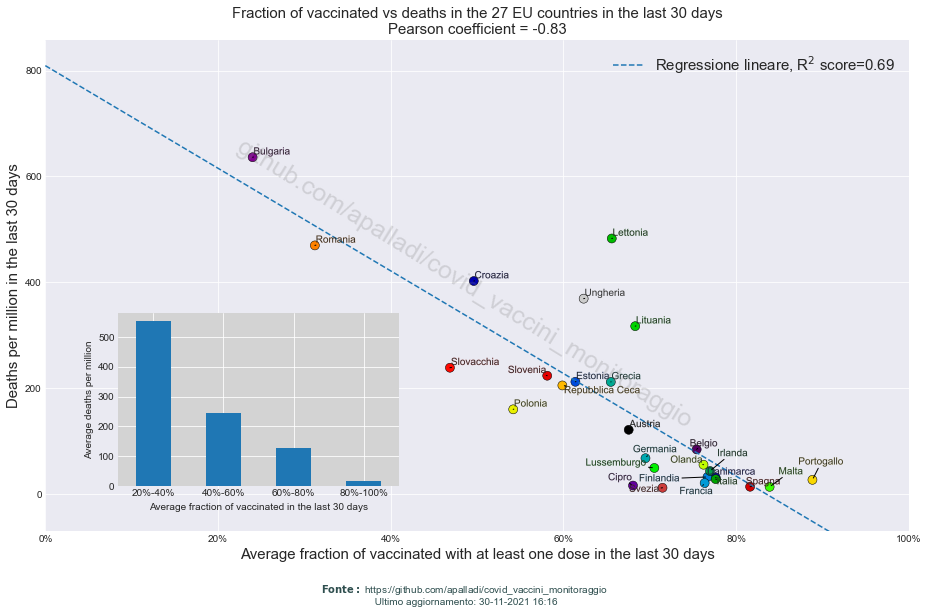

In [4]:
# Set locale to "it" to parse the month correctly
locale.setlocale(locale.LC_ALL, "it_IT.UTF-8")

# Imposta stile grafici
plt.style.use("seaborn-dark")

# importa dati
df_confirmed, df_deaths, df_recovered = import_epidem_data()
df_vacc = import_vaccines_data()


# plot correlazione vaccini vs. decessi per paesi eu
# calcola finestra temporale per cui si ottiene massima correlazione
window = 30  # giorni
# recupera dati per tale finestra temporale
vacc_res_2021, dec_res_2021 = compute_vaccini_decessi_eu(window, fully=False, last_day=False)
x_grid, y_grid, score = linear_fit(vacc_res_2021, dec_res_2021)
# calcola coefficiente di correlazione (pearson)
corr_coeff = round(np.corrcoef(vacc_res_2021, dec_res_2021)[0, 1], 2)

print("Finestra temporale scelta", window, "giorni")
print("Coefficiente di correlazione tra vaccinati e deceduti:", corr_coeff)

plot_correlazione_vaccini_decessi(vacc_res_2021,
                                  dec_res_2021,
                                  x_grid,
                                  y_grid,
                                  window,
                                  score)

R2 score è pari a 0.09
Finestra temporale scelta 30 giorni
Coefficiente di correlazione tra vaccinati e deceduti: -0.3
watermark fontsize: 25, angle:-31.61


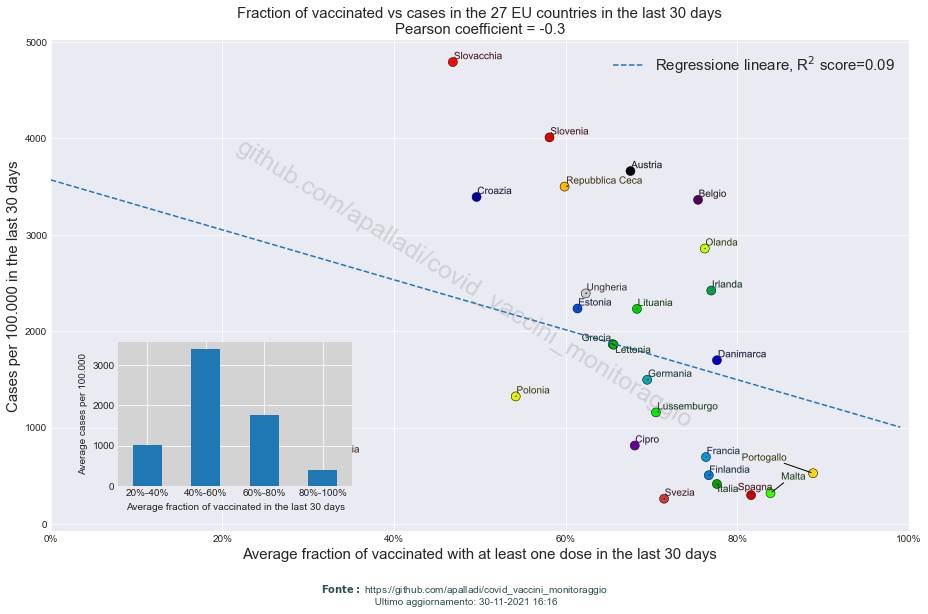

In [5]:
window=30
vacc_res_2021, casi_res_2021 = compute_vaccini_casi_eu(window, fully=False, last_day=False)
x_grid, y_grid, score = linear_fit(vacc_res_2021, casi_res_2021)
corr_coeff = round(np.corrcoef(vacc_res_2021, casi_res_2021)[0, 1], 2)

print("Finestra temporale scelta", window, "giorni")
print("Coefficiente di correlazione tra vaccinati e deceduti:", corr_coeff)

plot_correlazione_vaccini_casi(vacc_res_2021,
                               casi_res_2021,
                               x_grid,
                               y_grid,
                               window,
                               score)

### vaccini decesso EU in funzione del tempo

In [6]:
def vaccini_decesso_time_window(tw):
    window = tw  # giorni
    # recupera dati per tale finestra temporale
    vacc_res_2021, dec_res_2021 = compute_vaccini_decessi_eu(window, fully=False, last_day=False)
    # calcola coefficiente di correlazione (pearson)
    corr_coeff = np.corrcoef(vacc_res_2021, dec_res_2021)[0, 1]
    return corr_coeff

In [7]:
tw_grid = np.arange(5, 366, 5)

corr_vacc_dec_time = [np.abs(vaccini_decesso_time_window(tw)) for tw in tw_grid]

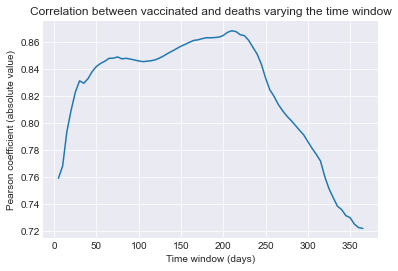

In [8]:
plt.plot(tw_grid, corr_vacc_dec_time)
plt.xlabel('Time window (days)')
plt.ylabel('Pearson coefficient (absolute value)')
plt.grid()
plt.title('Correlation between vaccinated and deaths varying the time window')
plt.savefig('custom_figures/corr_vaccini_decesso_time_window.png', dpi=300)
plt.show()

### Analisi vaccini decesso Italia

In [9]:
def load_report(date):
    url = 'https://raw.githubusercontent.com/apalladi/covid_vaccini_monitoraggio/main/dati/data_iss_et%C3%A0_'+str(date)+'.csv'
    df = pd.read_csv(url, sep=';')
    return df

df = load_report('2021-11-24')

pop = np.array([17435555, 18437505, 13572779, 4564103])
print('Popolazione totale', pop.sum())


num_attuali = [df.iloc[:, 9:12].sum().sum(), df.iloc[:, 13:16].sum().sum(), df.iloc[:, 17:20].sum().sum()]


tassi_vacc = np.array([df['ospedalizzati vaccinati'], 
                       df['terapia intensiva vaccinati'], 
                       df['decessi vaccinati']])/np.array(df['vaccinati completo'])

tassi_novacc = np.array([df['ospedalizzati non vaccinati'], 
                         df['terapia intensiva non vaccinati'], 
                         df['decessi non vaccinati']])/np.array(df['non vaccinati'])
              
tutti_vaccinati = (tassi_vacc*pop).sum(axis=1)
nessun_vaccinato = (tassi_novacc*pop).sum(axis=1)
over40_vaccinati = (tassi_vacc*[0, pop[1], pop[2], pop[3]]).sum(axis=1) + (tassi_novacc*[pop[0], 0, 0, 0]).sum(axis=1)
over60_vaccinati = (tassi_vacc*[0, 0, pop[2], pop[3]]).sum(axis=1) + (tassi_novacc*[pop[0], pop[1], 0, 0]).sum(axis=1)
over80_vaccinati = (tassi_vacc*[0, 0, 0, pop[3]]).sum(axis=1) + (tassi_novacc*[pop[0], pop[1], pop[2], 0]).sum(axis=1)

dec_prev = [tutti_vaccinati[2], over40_vaccinati[2], over60_vaccinati[2], 
            over80_vaccinati[2], nessun_vaccinato[2]]

dec_attuali = num_attuali[2]

Popolazione totale 54009942


In [10]:
# deceduti 
dec_reverse = dec_prev[::-1]
dec_reverse = np.append(dec_reverse, dec_reverse[-1])

# vaccinati
pop_reverse = pop[::-1]
pop_grid = np.cumsum(np.append(0, pop_reverse))
pop_grid = np.append(pop_grid, 60*10**6)

x_grid = 10**6*np.arange(0, 61, 1)


def fun_exp(x, x0):
    N = dec_reverse[0]
    q = dec_reverse[-1]
    y_pred = q+N*np.exp(-x/x0)
    return y_pred

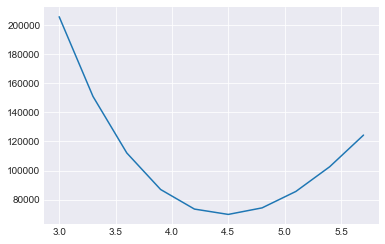

In [11]:
def to_minimize(par):
    y_pred = fun_exp(pop_grid, par*10**6)
    err = (y_pred - dec_reverse)**2
    return np.mean(err)
    
par_grid = np.arange(3, 6, 0.3)

y_grid = [to_minimize(par) for par in par_grid]

plt.plot(par_grid, y_grid)
plt.grid()
plt.show()

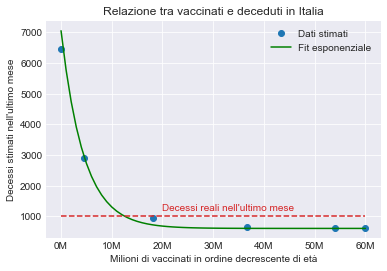

In [12]:
plt.plot(pop_grid, dec_reverse, linestyle='None', marker='o', label='Dati stimati')
plt.plot(x_grid, fun_exp(x_grid, 4.5*10**6), label='Fit esponenziale', color='green')
plt.plot(x_grid, x_grid*0+dec_attuali, linestyle='--', color='C3')
plt.text(20*10**6, 1200, 'Decessi reali nell\'ultimo mese', color='C3')
plt.xlabel('Milioni di vaccinati in ordine decrescente di età')
plt.ylabel('Decessi stimati nell\'ultimo mese')
plt.title('Relazione tra vaccinati e deceduti in Italia')
plt.xticks(10**6*np.arange(0, 61, 10), ['0M', '10M', '20M', '30M', '40M', '50M', '60M'])
plt.legend()
plt.grid()
plt.savefig('custom_figures/relazioni_vaccini_deceduti_Italia.png', dpi=300)